In [62]:
import numpy as np
import matplotlib.pyplot as plt
import os

% matplotlib inline

## Part (a) &mdash; Color-Magnitude Diagram for M92

In [23]:
### photometry data location
photpath = '/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/n6093_to_n6341_REAL/NGC6341.M92/final/REAL/NGC6341R.RDVIQ.cal.adj.zpt.txt'
### read in data
photdata = np.genfromtxt(photpath, skip_header=1, unpack=True)

`Readme` instructions say the `Vvega` column is F606W and the `Ivega` column is F814W. The corresponding F606W-F814W is given by the column `VIvega`.

In [25]:
### let's extract these columns for plotting
f606w = photdata[3]
f814w = photdata[7]
color = photdata[5]
### also get errors for later
err606 = photdata[4]
err814 = photdata[8]
errcol = photdata[6]

In [26]:
### turns out there's one point with a very high color value (not sure why), so let's ignore it
f606w = f606w[np.where(color < 60)[0]]
f814w = f814w[np.where(color < 60)[0]]
color = color[np.where(color < 60)[0]]
# and for errors
err606 = err606[np.where(color < 60)[0]]
err814 = err814[np.where(color < 60)[0]]
errcol = errcol[np.where(color < 60)[0]]

In [41]:
### also, there is some garbage where the error on 606 and color is 99.999
ii = np.where(errcol != 99.999)
f606w = f606w[ii]
f814w = f814w[ii]
color = color[ii]
err606 = err606[ii]
err814 = err814[ii]
errcol = errcol[ii]

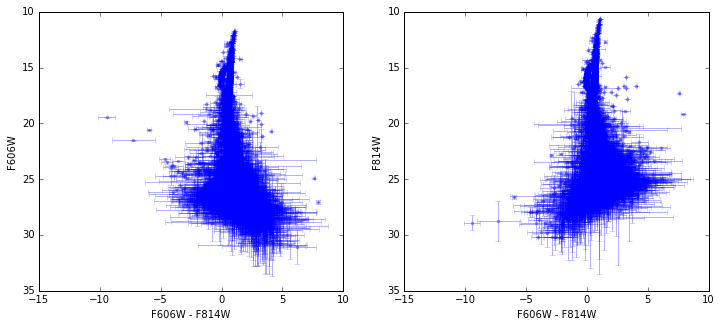

In [42]:
### now let's plot
fig1, ax1 = plt.subplots(1,2,figsize=(12,5))
ax1[0].errorbar(f606w-f814w, f606w, xerr=errcol, yerr=err606 , fmt='.', alpha=0.3)
ax1[0].invert_yaxis()
ax1[0].set_xlabel('F606W - F814W')
ax1[0].set_ylabel('F606W')
ax1[1].errorbar(f606w-f814w, f814w, xerr=errcol, yerr=err814 , fmt='.', alpha=0.3)
ax1[1].invert_yaxis()
ax1[1].set_xlabel('F606W - F814W')
ax1[1].set_ylabel('F814W')
plt.show()

## Part (b) &mdash; Isochrone fitting

From class discussion and reading about M92 etc, it seems that it is an old, metal-poor cluster, so it doesn't make sense to explore the parameter space of small ages and high metallicities.

So, let's say the age of the cluster is between 8 and 18 Gyr, which in log space corresponds to values of $\log_{10}$(age) between 9.9 and 10.26.

Also, let's say metallicity is between -2.5 and -2.0. (most literature values seems to be close to -2.3)

There is also the issue of extinction. All of the papers I've seen use E(B-V)=0.02, which is consistent with the value quoted on NED of Av = 0.061 (this is assuming that Rv = 3.1, which a lot of people seem to do). So at this point I'm just going to do what everybody else seems to do and use the NED value Av = 0.061. 

In [61]:
log10ages = [9.90, 9.95, 10.00, 10.05, 10.10, 10.15, 10.20, 10.25]
feh = [-2.50, -2.45, -2.40, -2.35, -2.30, -2.25, -2.20, -2.15, -2.10, -2.05, -2.00]

In [64]:
### isochrone data location
isodir = '/Users/iene/Documents/Classes/ay250_fall2016/pset3/data/isochrones'
isopath = lambda feh: os.path.join(isodir, 'MIST_iso_feh{0:.2f}.txt'.format(feh))
isodata = np.genfromtxt(isopath(2.30), skip_header=12, names=True, unpack=True)

In [66]:
### now let's get isochrone magnitudes
iso606 = isodata['Bessell_R']
iso814 = isodata['Bessell_I']
isocolor = iso606 - iso814
ages = isodata['log10_isochrone_age_yr']

In [68]:
age = np.where(np.round(ages, decimals=2) == 10.15)

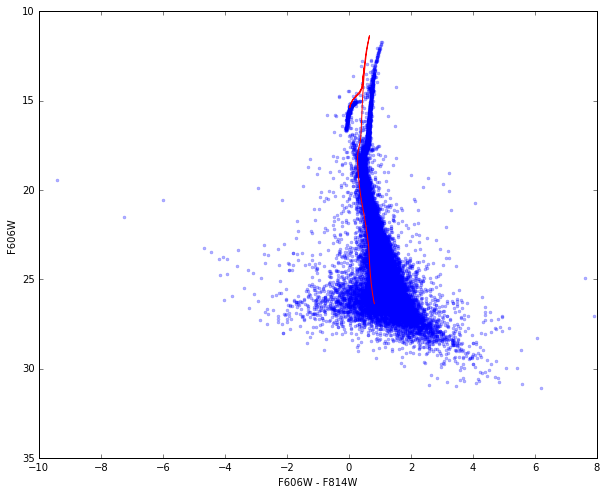

In [71]:
fig = plt.figure(figsize=(10,8))
plt.plot(f606w-f814w, f606w, '.', alpha=0.3)

plt.plot(isocolor[age], iso606[age] + 14.6, 'r')
plt.gca().invert_yaxis()
plt.xlabel('F606W - F814W')
plt.ylabel('F606W')
plt.show()

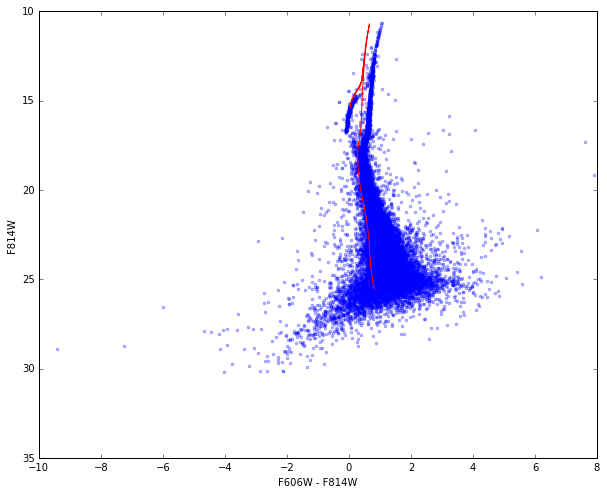

In [70]:
fig = plt.figure(figsize=(10,8))
plt.plot(f606w-f814w, f814w, '.', alpha=0.3)

plt.plot(isocolor[age], iso814[age] + 14.6, 'r')
plt.gca().invert_yaxis()
plt.xlabel('F606W - F814W')
plt.ylabel('F814W')
plt.show()